In [1]:
import numpy as np  
import math
from enum import Enum

# matplotlib
# ライブラリーのインポート
import matplotlib.pyplot as plt
# インライン表示
%matplotlib inline

# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)

# ipynbのインポート
import nbimporter
from common_data import get_calendar, calc_theta_ex_ave, get_Q_value

Importing Jupyter notebook from common_data.ipynb


# 家電

## 9.　温水暖房洗浄便座（ver自立P4）

### 9.1　定義

温水暖房洗浄便座の動作状態および機能は、以下を想定する。

* 稼働－便座加温
* 稼働－洗浄水
* 稼働－便座保温
* 稼働－洗浄水保温

便座および洗浄水のヒータ加熱方式に非瞬間式と瞬間式とがある。また、電源スイッチにより機能の有効・無効を切り替えることができる。無効化された場合、消費電力はゼロとなる。

想定する動作状態および機能に対応する添え字は、以下のとおりである。

|機器の動作状態 |機器の機能 |添え字    |備考                                   |  
|:-------------:|:---------:|:--------:|:-------------------------------------:|    
|稼働           |便座加温   |opg,ht,st |機能が無効化された場合、消費電力はゼロ |  
|稼働           |洗浄水加温 |opg,ht,wt |機能が無効化された場合、消費電力はゼロ |   
|稼働           |便座保温   |opg,kp,st |機能が無効化された場合、消費電力はゼロ |    
|稼働           |洗浄水保温 |opg,kp,wt |機能が無効化された場合、消費電力はゼロ |    

In [2]:
class HeaterType(Enum):
    '''ヒータの加熱方式'''
    # NonInst：非瞬間方式（NonInstantaneously）
    # Inst：瞬間方式（Instantaneously）

    NonInst = 'noninst'
    Inst = 'inst'

In [3]:
class HeaterSwitch(Enum):
    '''ヒータの電源スイッチ'''
    # Off：オフ
    # On：オン

    Off = 'off'
    On = 'on'

### 9.2　消費電力量

日付$d$の時刻$t$における温水洗浄暖房便座の消費電力量は、式(1)により表される。

$$ 
\begin{equation*}
    E_{E,ToiletSeat,d,t} = E_{E,opg,d,t}
\end{equation*}
$$


<div style="text-align: right;"> (1) </div>

ここで、  

$E_{E,ToiletSeat,d,t}$：日付$d$の時刻$t$における温水洗浄便座の単位時間当たりの消費電力量[Wh]  
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]  

である。

In [4]:
def EE_app (EE_opg):
    '''消費電力量[Wh]を計算する'''
    # EE_opg：稼働時の消費電力量[Wh]
    
    return EE_opg

日付$d$の時刻$t$における稼働時および待機時の消費電力量は、式(2)により計算される。

<p style="text-indent:2em">稼働時の消費電力量：</p>  
$$ 
\begin{equation*}
    E_{E,opg,d,t} = P_{opg,ht,d,t} \times dt_{opg,ht,d,t}  \div 3600 + P_{opg,kp,d,t} \times dt_{opg,kp,d,t}  \div 3600
\end{equation*}
$$

<div style="text-align: right;"> (2) </div>

ただし、式(3)を満たす。  

$$ 
\begin{equation*}
    dt_{opg,ht,d,t} +dt_{opg,kp,d,t} = dt_{calc}
\end{equation*}
$$
<div style="text-align: right;"> (3) </div>

ここで、  

$dt_{calc}$：単位時間[s]   
$dt_{opg,ht,d,t}$：日付$d$の時刻$t$において加温が機能することによる稼働時間の合計[s]  
$dt_{opg,kp,d,t}$：日付$d$の時刻$t$において保温が機能することによる稼働時間の合計[s]   
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]    
$P_{opg,ht,d,t}$：日付$d$の時刻$t$において加温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,d,t}$：日付$d$の時刻$t$において保温が機能することによる稼働時の消費電力[W]  

である。

In [5]:
def EE_opg (P_opg_ht, P_opg_kp, dt_opg_ht, dt_opg_kp):
    '''稼働時の消費電力量[Wh]を計算する'''
    # P_opg_ht：加温が機能することによる稼働時の消費電力[W] 
    # P_opg_kp：保温が機能することによる稼働時の消費電力[W] 
    # dt_opg_ht：加温が機能することによる稼働時間の合計[s]
    # dt_opg_kp：保温が機能することによる稼働時間の合計[s]
  
    return P_opg_ht * dt_opg_ht / 3600 + P_opg_kp * dt_opg_kp / 3600

In [6]:
def check_duration (dt):
    '''合計が単位時間を超過しないか否かを確認する'''
    # dt：稼働時間の合計[s](list型)
    # dt_calc：単位時間[s]
    
    dt_calc = 3600.
    
    # 継続時間を積算する
    dt_sum = sum(dt)
    
    # エラーチェック
    if dt_calc != dt_sum:
        # 単位時間と異なる => エラー
        try:
            raise Exception('動作スケジュールに不正があります。')
        except Exception:
            raise
    else:
        pass

### 9.3　稼働時の消費電力

日付$d$の時刻$t$における稼働時の消費電力は、暖房便座が機能することによる消費電力と温水洗浄が機能することによる消費電力の合計であり、式(4)により計算される。

<p style="text-indent:2em">稼働時の消費電力量：</p>  
<p style="text-indent:4em">加温の場合：</p>  
$$ 
\begin{equation*}
    P_{opg,ht,d,t} =  P_{opg,ht,st,d,t} + P_{opg,ht,wt,d,t}
\end{equation*}
$$

<div style="text-align: right;"> (4-1) </div>

<p style="text-indent:4em">保温の場合：</p>  
$$ 
\begin{equation*}
    P_{opg,kp,d,t} =  P_{opg,kp,st,d,t} + P_{opg,kp,wt,d,t}
\end{equation*}
$$

<div style="text-align: right;"> (4-2) </div>

ここで、  

$P_{opg,ht,d,t}$：日付$d$の時刻$t$において加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,wt,d,t}$：日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,d,t}$：日付$d$の時刻$t$において保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,st,d,t}$：日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,wt,d,t}$：日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]  


である。

In [7]:
def P_opg_ht(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_switch, theta_toilet_ave):
    '''加温が機能することによる稼働時の消費電力[W]を計算する'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W]  
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_type：便座ヒータの加熱方式[非瞬間方式、瞬間方式] (Enum型) 
    # water_heater_type：洗浄水ヒータの加熱方式[非瞬間方式、瞬間方式] (Enum型) 
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン] (Enum型)
    # theta_toilet_ave：トイレ空気温度の日平均値[C]  
    
    if seat_heater_type == HeaterType.NonInst and water_heater_type == HeaterType.NonInst:
        return P_opg_ht_noninst_noninst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave)
    
    elif seat_heater_type == HeaterType.Inst and water_heater_type == HeaterType.NonInst:
        return P_opg_ht_inst_noninst(Prtd_opg_wt, seat_heater_switch, theta_toilet_ave)
        
    elif seat_heater_type == HeaterType.NonInst and water_heater_type == HeaterType.Inst:
        return P_opg_ht_noninst_inst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch,  theta_toilet_ave)
        
    elif seat_heater_type == HeaterType.Inst and water_heater_type == HeaterType.Inst:
        return P_opg_ht_inst_inst(theta_toilet_ave)
    else:
        raise Exception

In [8]:
def P_opg_kp(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_switch, theta_toilet_ave):
    '''保温が機能することによる稼働時の消費電力[W]を計算する'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W]  
    # Prtd_opg_ht：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_type：便座ヒータの加熱方式[非瞬間方式、瞬間方式] (Enum型) 
    # water_heater_type：洗浄水ヒータの加熱方式[非瞬間方式、瞬間方式] (Enum型) 
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン] (Enum型) 
    # theta_toilet_ave：トイレ空気温度の日平均値[C]  
    
    if seat_heater_type == HeaterType.NonInst and water_heater_type == HeaterType.NonInst:
        return P_opg_kp_noninst_noninst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave)
    
    elif seat_heater_type == HeaterType.Inst and water_heater_type == HeaterType.NonInst:
        return P_opg_kp_inst_noninst(Prtd_opg_wt, seat_heater_switch, theta_toilet_ave)
    
    elif seat_heater_type == HeaterType.NonInst and water_heater_type == HeaterType.Inst:
        return P_opg_kp_noninst_inst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave)
    
    elif seat_heater_type == HeaterType.Inst and water_heater_type == HeaterType.Inst:
        return P_opg_kp_inst_inst(theta_toilet_ave)
    else:
        raise Exception

日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力および日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力は、ヒータ加熱方式に応じて式(5)により計算される。

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が非瞬間方式の場合：  </p>
<p style="text-indent:4em">便座加温が機能することによる消費電力：</p>
<p style="text-indent:6em">便座ヒータの電源がオフ</p>
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = 0
\end{equation*}
$$       
<div style="text-align: right;"> (5a-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン</p>
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = P_{opg,ht,st,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5a-2) </div>
  
<p style="text-indent:4em">洗浄水加温が機能することによる消費電力： </p>
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,wt,d,t} = P_{opg,ht,wt,noninst,d,t}
\end{equation*}
$$        
<div style="text-align: right;"> (5a-3) </div>

ここで、  

$P_{opg,ht,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]   
$P_{opg,ht,wt,d,t}$：日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]    

である。  

In [9]:
def P_opg_ht_noninst_noninst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が非瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W] 
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン](Enum型)   
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 便座加温が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_ht_st = 0        
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_ht_st = P_opg_ht_st_noninst(Prtd_opg_st, theta_toilet_ave)
    else:
        raise Exception
    
    # 洗浄水加温が機能することによる消費電力[W]
    P_opg_ht_wt = P_opg_ht_wt_noninst(Prtd_opg_wt, theta_toilet_ave) 
    
    return P_opg_ht_st + P_opg_ht_wt

<p style="text-indent:2em">便座のヒータ加熱方式が瞬間方式＋洗浄水のヒータ加熱方式が非瞬間方式の場合：</p> 
<p style="text-indent:4em">便座加温が機能することによる消費電力：</p> 
<p style="text-indent:6em">便座ヒータの電源がオフ</p> 
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = 0
\end{equation*}
$$
<div style="text-align: right;"> (5b-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = P_{opg,ht,st,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5b-2) </div>
        
<p style="text-indent:4em">洗浄水加温が機能することによる消費電力：</p>
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,wt,d,t} =  P_{opg,ht,wt,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5b-3) </div>

ここで、  

$P_{opg,ht,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,st,{\textit inst},d,t}$：便座のヒータ加熱方式が瞬間式、洗浄水加温のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]    
$P_{opg,ht,wt,d,t}$：日付$d$の時刻$t$において洗浄水加温が機能する場合の稼働時の消費電力[W]  
$P_{opg,ht,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]    

である。  

In [10]:
def P_opg_ht_inst_noninst(Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座のヒータ加熱方式が瞬間方式＋洗浄水のヒータ加熱方式が非瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン] (Enum型)  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 暖房便座が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_ht_st = 0      
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_ht_st = P_opg_ht_st_inst(theta_toilet_ave) 
    else:
        raise Exception
    
    # 温水洗浄が機能することによる消費電力[W]
    P_opg_ht_wt = P_opg_ht_wt_noninst(Prtd_opg_wt, theta_toilet_ave)

    return P_opg_ht_st + P_opg_ht_wt

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間方式＋洗浄水のヒータ加熱方式が瞬間方式の場合：</p>  
<p style="text-indent:4em">便座加温が機能することによる消費電力：</p>  
<p style="text-indent:6em">便座ヒータの電源がオフ：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = 0
\end{equation*}
$$
<div style="text-align: right;"> (5c-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} = P_{opg,ht,st,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5c-2) </div>
        
<p style="text-indent:4em">洗浄水加温が機能することによる消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,wt,d,t} =  P_{opg,ht,wt,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5c-3) </div>

ここで、  

$P_{opg,ht,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]    
$P_{opg,ht,wt,d,t}$：日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,wt,{\textit inst},d,t}$：便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]   

である。  

In [11]:
def P_opg_ht_noninst_inst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座のヒータ加熱方式が非瞬間方式＋洗浄水のヒータ加熱方式が瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W] 
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン]   
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
            
    # 便座加温が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_ht_st = 0      
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_ht_st =P_opg_ht_st_noninst(Prtd_opg_st, theta_toilet_ave)
    else:
        raise Exception
    
    # 洗浄水加温が機能することによる消費電力[W]
    P_opg_ht_wt = P_opg_ht_wt_inst(Prtd_opg_wt, theta_toilet_ave)

    
    return P_opg_ht_st + P_opg_ht_wt

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合（便座ヒータのオフは考慮しない）：</p>  
<p style="text-indent:4em">便座加温が機能することによる稼働時の消費電力と洗浄水加温が機能することによる稼働時の消費電力との合計：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,ht,st,d,t} + P_{opg,ht,wt,d,t} = P_{opg,ht,sw,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (5d) </div>

ここで、  

$P_{opg,ht,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,ht,sw,{\textit inst},d,t}$：便座と洗浄水の両方のヒータ加熱方式が瞬間式で、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力と洗浄水加温が機能することによる稼働時の消費電力との合計[W]  
$P_{opg,ht,wt,d,t}$：日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  

である。  

In [12]:
def P_opg_ht_inst_inst(theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合の稼働時の消費電力を計算する[W]'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 便座加温が機能することによる消費電力と洗浄水加温が機能することによる消費電力との合計[W]
    P_opg_ht_sw = P_opg_ht_sw_inst(theta_toilet_ave)
    
    return P_opg_ht_sw

便座加温が機能することによる稼働時の消費電力および洗浄水加温が機能することによる稼働時の消費電力は、ヒータ加熱方式およびヒータ電源の状態に応じて式(6)により計算される。ただし、計算値がマイナスの場合は消費電力はゼロとする。

なお、計算式から求まる消費電力は、厳密には平均消費電力であり、瞬時の消費電力ではない。

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間式の場合において、便座加温が機能することによる稼働時の消費電力：</p>
<p style="text-indent:4em">便座ヒータの定格消費電力 $P_{rtd,opg,st} \leq 45 $ の場合：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,st,noninst,d,t} = max \left( 0.0, \left( -0.0201 \times \theta_{toilte,ave,d} + 0.9224 \times \left( \frac{P_{rtd,opg,st}}{45} \right)\right) \times 1000 \bigg/ 24 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6a-1) </div>
　　
<p style="text-indent:4em">$45 <$ 便座ヒータの定格消費電力 $P_{rtd,opg,st} < 50 $ の場合：</p>   
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,st,noninst,d,t} = max \left( 0.0, \left( -0.0201 \times \theta_{toilet,ave,d} -5.25 \times 10^{-4} \times \left( P_{rtd,opg,st}-45 \right) + 0.923 + 0.0157 \times \left( P_{rtd,opg,st} - 45 \right) \right) \times 1000 \bigg/ 24 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6a-2) </div>
　　
<p style="text-indent:4em">$50 \leq$ 便座ヒータの定格消費電力 $P_{rtd,opg,st} $ の場合：</p> 
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,st,noninst,d,t} = max \left( 0.0, \left( -0.023 \times \theta_{toilte,ave,d} + 1.0042 \times \left( \frac{P_{rtd,opg,st}}{50} \right)\right) \times 1000 \bigg/ 24 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6a-3) </div>

ここで、  

$P_{opg,ht,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]   
$P_{rtd,opg,st}$：便座ヒータの定格消費電力[W]  
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [13]:
def P_opg_ht_st_noninst(Prtd_opg_st, theta_toilet_ave):
    '''便座のヒータ加熱方式が非瞬間式の場合において
    　 便座加温が機能することによる稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W] 
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
            
    if Prtd_opg_st <= 45:
        return max(0.0, (-0.0201 * theta_toilet_ave + 0.9224 * (Prtd_opg_st / 45)) *1000 / 24)
    elif 45 < Prtd_opg_st and  Prtd_opg_st < 50:
        return max(0.0, (-0.0201 * theta_toilet_ave -5.25 * (10**-4) * (Prtd_opg_st - 45) + 0.923 + 0.0157 * (Prtd_opg_st - 45)) *1000 / 24)
    elif 50 <= Prtd_opg_st:
        return max(0.0, (-0.023 * theta_toilet_ave + 1.0042 * (Prtd_opg_st / 50)) *1000 / 24)
    else:
        raise Exception

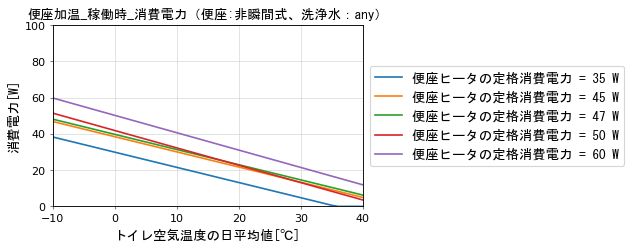

In [14]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('便座加温_稼働時_消費電力（便座:非瞬間式、洗浄水：any）', fontdict={'fontproperties':fp})

for i,Prtd in enumerate([35, 45, 47, 50, 60]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [P_opg_ht_st_noninst(Prtd, theta_toilet_ave) for theta_toilet_ave in x_values]
    plt.plot(x_values, y_values, label='便座ヒータの定格消費電力 = '+str(Prtd)+' W')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 120, 20), minor=False)
ax.set_ybound(lower=0, upper=100)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')   
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

<p style="text-indent:2em">洗浄水のヒータ加熱方式が非瞬間式の場合において、洗浄水加温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,wt,noninst,d,t} = max \left( 0.0, \left( -0.0144 \times \theta_{toilet,ave,d} + 0.5121 \times \left( \frac{P_{rtd,opg,wt}}{500} \right) \right) \times 1000 \bigg/ 24 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6b) </div>

ここで、  

$P_{opg,ht,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{rtd,opg,wt}$：洗浄水ヒータの定格消費電力[W]  
$\theta_{toilet,ave}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [15]:
def P_opg_ht_wt_noninst(Prtd_opg_wt, theta_toilet_ave):
    '''洗浄水のヒータ加熱方式が非瞬間式の場合において
    　 洗浄水加温が機能することによる稼働時の消費電力を計算する[W]'''
    # Prtd_opg_ht：洗浄水ヒータの定格消費電力[W]  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    return max (0.0, (-0.0144 * theta_toilet_ave + 0.5121 * (Prtd_opg_wt / 500)) * 1000 / 24)

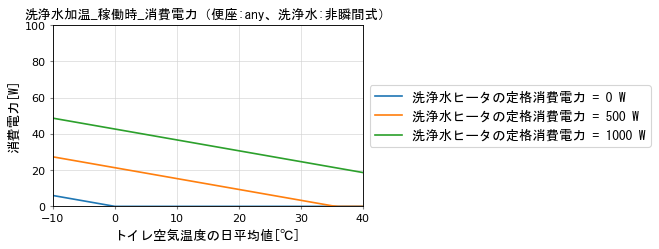

In [16]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('洗浄水加温_稼働時_消費電力（便座:any、洗浄水:非瞬間式）', fontdict={'fontproperties':fp})

for i,Prtd in enumerate([0, 500, 1000]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [P_opg_ht_wt_noninst(Prtd, theta_toilet_ave) for theta_toilet_ave in x_values]
    plt.plot(x_values, y_values, label='洗浄水ヒータの定格消費電力 = '+str(Prtd)+' W')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 120, 20), minor=False)
ax.set_ybound(lower=0, upper=100)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

<p style="text-indent:2em">便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において、便座加温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,st,{\textit inst},d,t} = max \left(0.0, -0.195 \times \theta_{toilet,ave,d} + 8.313 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6c) </div>

ここで、  

$P_{opg,ht,st,{\textit inst},d,t}$：便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [17]:
def P_opg_ht_st_inst(theta_toilet_ave):
    '''便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において、
    　 便座加温が機能することによる稼働時の消費電力を計算する[W]'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]  
    
    return max(0.0, -0.195 * theta_toilet_ave + 8.313)

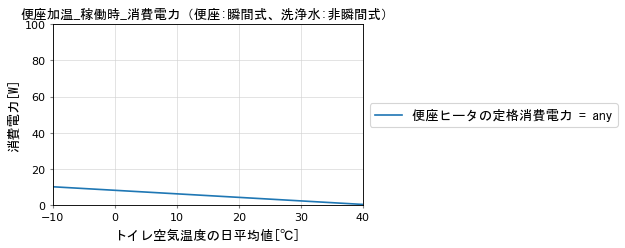

In [18]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('便座加温_稼働時_消費電力（便座:瞬間式、洗浄水:非瞬間式）', fontdict={'fontproperties':fp})

x_values = [x for x in range(-10, 45, 1)]
y_values = [P_opg_ht_st_inst(theta_toilet_ave) for theta_toilet_ave in x_values]
plt.plot(x_values, y_values, label='便座ヒータの定格消費電力 = any')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 120, 20), minor=False)
ax.set_ybound(lower=0, upper=100)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')    
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間式、および洗浄水のヒータ加熱方式が瞬間式の場合において、洗浄水加温が機能することによる稼働時の消費電力：</p>  
$$
\begin{equation*}
    \displaystyle P_{opg,ht,wt,{\textit inst},d,t} =  max \left(0.0, \left(-1.274 \times 10^{-6} \times \theta_{toilet,ave,d} \times P_{rtd,opg,wt} + 0.0357 \times 10^{-3} \times P_{rtd,opg,wt} \right) \times 1000 \bigg/ 24 \right)
\end{equation*}
$$
<div style="text-align: right;"> (6d) </div>

ここで、  

$P_{opg,ht,wt,{\textit inst},d,t}$：便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{rtd,opg,wt}$：洗浄水ヒータの定格消費電力[W]  
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [19]:
def P_opg_ht_wt_inst(Prtd_opg_wt, theta_toilet_ave):
    '''便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において
    　 洗浄水加温が機能することによる稼働時の消費電力を計算する[W]'''
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    return max(0.0, (-1.274 * 10**-6 * theta_toilet_ave * Prtd_opg_wt + 0.0357 * 10**-3 * Prtd_opg_wt) * 1000 / 24)

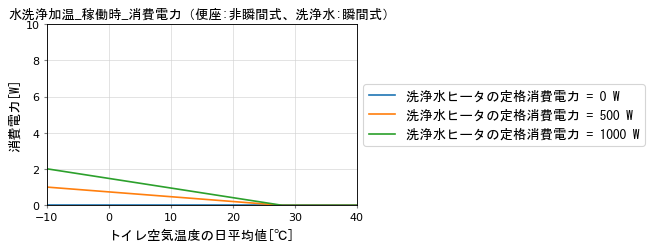

In [20]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('水洗浄加温_稼働時_消費電力（便座:非瞬間式、洗浄水:瞬間式）', fontdict={'fontproperties':fp})

for i,Prtd in enumerate([0, 500, 1000]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [P_opg_ht_wt_inst(Prtd, theta_toilet_ave) for theta_toilet_ave in x_values]
    plt.plot(x_values, y_values, label='洗浄水ヒータの定格消費電力 = '+str(Prtd)+' W')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 12, 2), minor=False)
ax.set_ybound(lower=0, upper=10)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')   
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合において、便座加温が機能することによる稼働時の消費電力と洗浄水加温が機能することによる稼働時の消費電力との合計：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,ht,sw,{\textit inst},d,t} = max \left( 0.0, \left( -0.195 \times \theta_{toilet,ave,d} + 8.313 \right) \bigg/ \frac{5}{60} \right)
\end{equation*}
$$
<div style="text-align: right;"> (6e) </div>

ここで、  

$P_{opg,ht,sw,{\textit inst},d,t}$：便座と洗浄水の両方のヒータ加熱方式が瞬間式で、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力と洗浄水加温が機能することによる稼働時の消費電力との合計[W]   
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [21]:
def P_opg_ht_sw_inst(theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が瞬間式で、
    　 便座加温が機能することによる稼働時の消費電力と洗浄水加温が機能することによる稼働時の消費電力との合計を計算する[W]'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    return  max(0.0, (-0.195 * theta_toilet_ave + 8.313) / (5 / 60))

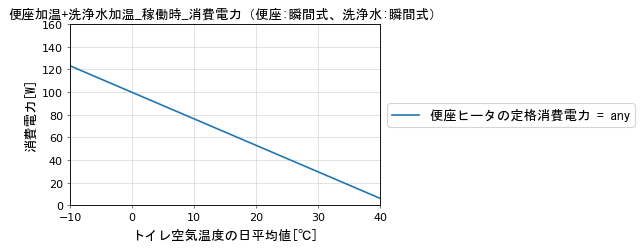

In [22]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('便座加温+洗浄水加温_稼働時_消費電力（便座:瞬間式、洗浄水:瞬間式）', fontdict={'fontproperties':fp})

x_values = [x for x in range(-10, 45, 1)]
y_values = [P_opg_ht_sw_inst(theta_toilet_ave) for theta_toilet_ave in x_values]
plt.plot(x_values, y_values, label='便座ヒータの定格消費電力 = any')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 220, 20), minor=False)
ax.set_ybound(lower=0, upper=160)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')    
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力および日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力は、ヒータ加熱方式に応じて式(7)により計算される。

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が非瞬間方式の場合：</p>  
<p style="text-indent:4em">便座保温が機能することによる消費電力：</p>  
<p style="text-indent:6em">便座ヒータの電源がオフ：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = 0
\end{equation*}
$$
<div style="text-align: right;"> (7a-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = P_{opg,kp,st,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7a-2) </div>
        
<p style="text-indent:4em">洗浄水保温が機能することによる消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,wt,d,t} =  P_{opg,kp,wt,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7a-3) </div>

ここで、  

$P_{opg,kp,st,d,t}$：日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]   
$P_{opg,kp,wt,d,t}$：日付$d$の時刻$t$において洗浄水保温が機能することによる待機時の消費電力[W]  
$P_{opg,kp,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水保温が機能することによる科小津時の消費電力[W]    

である。  

In [23]:
def P_opg_kp_noninst_noninst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が非瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W] 
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン](Enum型) 
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 便座保温が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_kp_st = 0       
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_kp_st = P_opg_kp_st_noninst(Prtd_opg_st, theta_toilet_ave)
    else:
        raise Exception
   
    # 洗浄水保温が機能することによる消費電力[W]
    P_opg_kp_wt = P_opg_kp_wt_noninst(Prtd_opg_wt, theta_toilet_ave) 
    
    return P_opg_kp_st + P_opg_kp_wt

<p style="text-indent:2em">便座のヒータ加熱方式が瞬間方式＋洗浄水のヒータ加熱方式が非瞬間方式の場合：</p>  
<p style="text-indent:4em">便座保温が機能することによる消費電力：</p>    
<p style="text-indent:6em">便座ヒータの電源がオフ：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = 0
\end{equation*}
$$
<div style="text-align: right;"> (7b-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン：</p>  
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = P_{opg,kp,st,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7b-2) </div>

<p style="text-indent:4em">温水洗浄が機能することによる消費電力：</p>    
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,wt,d,t} =  P_{opg,kp,wt,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7b-3) </div>

ここで、  

$P_{opg,kp,st,d,t}$：日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,st,{\textit inst},d,t}$：便座のヒータ加熱方式が瞬間方式、洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,wt,d,t}$：日付$d$の時刻$t$において洗浄水保温が機能する場合の稼働時の消費電力[W]  
$P_{opg,kp,wt,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]    

である。  

In [24]:
def P_opg_kp_inst_noninst(Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座のヒータ加熱方式が瞬間方式＋水洗浄のヒータ加熱方式が非瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン] 
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 便座保温が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_kp_st = 0
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_kp_st = P_opg_kp_inst()
    else:
        raise Exception
    
    # 水洗浄保温が機能することによる消費電力[W]
    P_opg_kp_wt = P_opg_kp_wt_noninst(Prtd_opg_wt, theta_toilet_ave)

    return P_opg_kp_st + P_opg_kp_wt

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間方式＋洗浄水のヒータ加熱方式が瞬間方式の場合：</p>   
<p style="text-indent:4em">便座保温が機能することによる消費電力：</p>   
<p style="text-indent:6em">便座ヒータの電源がオフ：</p>      
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = 0
\end{equation*}
$$
<div style="text-align: right;"> (7c-1) </div>

<p style="text-indent:6em">便座ヒータの電源がオン：</p>      
$$  
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} = P_{opg,kp,st,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7c-2) </div>
            
<p style="text-indent:4em">水洗浄保温が機能することによる消費電力：</p>
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,wt,d,t} =  P_{opg,kp,wt,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7c-3) </div>

ここで、  

$P_{opg,kp,st,d,t}$：日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]    
$P_{opg,kp,wt,d,t}$：日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,wt{\textit inst},d,t}$：便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式で、日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]   

である。  

In [25]:
def P_opg_kp_noninst_inst(Prtd_opg_st, Prtd_opg_wt, seat_heater_switch, theta_toilet_ave):
    '''便座のヒータ加熱方式が非瞬間方式＋洗浄水のヒータ加熱方式が瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W] 
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン](Enum型)  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
            
    # 便座保温が機能することによる消費電力[W]
    if seat_heater_switch == HeaterSwitch.Off:
        P_opg_kp_st = 0 
    elif seat_heater_switch == HeaterSwitch.On:
        P_opg_kp_st =P_opg_kp_st_noninst(Prtd_opg_st, theta_toilet_ave)
    else:
        raise Exception
            
    # 水洗浄保温が機能することによる消費電力[W]
    P_opg_kp_wt = P_opg_kp_wt_inst()
    
    return P_opg_kp_st + P_opg_kp_wt

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が瞬間方式の場合（便座ヒータのオフは考慮しない）：</p>  
<p style="text-indent:4em">便座保温が機能することによる消費電力と洗浄水保温が機能することによる消費電力との合計：</p>  
$$
\begin{equation*}
    \displaystyle P_{opg,kp,st,d,t} + P_{opg,kp,wt,d,t} = P_{opg,kp,sw,{\textit inst},d,t}
\end{equation*}
$$
<div style="text-align: right;"> (7d) </div>

ここで、  

$P_{opg,kp,st,d,t}$：日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,sw,{\textit inst},d,t}$：便座と洗浄水の両方のヒータ加熱方式が瞬間式で、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力と洗浄水保温が機能することによる稼働時の消費電力との合計[W]  
$P_{opg,kp,wt,d,t}$：日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]    

である。  

In [26]:
def P_opg_kp_inst_inst(theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が瞬間方式の場合の稼働時の消費電力を計算する[W]'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    # 便座保温が機能することによる消費電力と洗浄水保温が機能することによる消費電力との合計[W]
    P_opg_kp_sw = P_opg_kp_sw_inst(theta_toilet_ave) 
    
    return P_opg_kp_sw

便座保温が機能することによる稼働時の消費電力および洗浄水保温が機能することによる待機時の消費電力は、ヒータ加熱方式およびヒータ電源の状態に応じて式(8)により計算される。ただし、計算値がマイナスの場合は消費電力はゼロとする。

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間式の場合において、便座保温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,st,noninst,d,t} = P_{opg,ht,st,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (8a) </div>

ここで、  

$P_{opg,ht,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座加温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,st,noninst,d,t}$：便座のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  

である。

In [27]:
def P_opg_kp_st_noninst(Prtd_opg_st, theta_toilet_ave):
    '''便座のヒータ加熱方式が非瞬間式の場合において
    　 便座保温が機能することによる稼働時の消費電力を計算する[W]'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W]  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    return P_opg_ht_st_noninst(Prtd_opg_st, theta_toilet_ave)

<p style="text-indent:2em">洗浄水のヒータ加熱方式が非瞬間式の場合において、洗浄水保温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,wt,noninst,d,t} = P_{opg,ht,wt,noninst,d,t}
\end{equation*}
$$
<div style="text-align: right;"> (8b) </div>

ここで、  

$P_{opg,ht,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水加温が機能することによる稼働時の消費電力[W]  
$P_{opg,kp,wt,noninst,d,t}$：洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]  

である。

In [28]:
def P_opg_kp_wt_noninst(Prtd_opg_wt, theta_toilet_ave):
    '''洗浄水のヒータの加熱方式が非瞬間式の場合において
    　 洗浄水保温が機能することによる稼働時の消費電力を計算する[W]'''
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    return P_opg_ht_wt_noninst(Prtd_opg_wt, theta_toilet_ave)

<p style="text-indent:2em">便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において、便座保温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,st,{\textit inst},d,t} = 0
\end{equation*}
$$  
<div style="text-align: right;"> (8c) </div>

ここで、  

$P_{opg,kp,st,{\textit inst},d,t}$：便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力[W]  

である。

In [29]:
def P_opg_kp_st_inst():
    '''便座のヒータ加熱方式が瞬間式、洗浄水のヒータ加熱方式が非瞬間式の場合において
    　 便座保温が機能することによる稼働時の消費電力を計算する[W]'''
    
    return 0.0

<p style="text-indent:2em">便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において、洗浄水保温が機能することによる稼働時の消費電力：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,wt,{\textit inst},d,t} = 0
\end{equation*}
$$  
<div style="text-align: right;"> (8d) </div>

ここで、  

$P_{opg,kp,wt,{\textit inst},d,t}$：便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において、日付$d$の時刻$t$において洗浄水保温が機能することによる稼働時の消費電力[W]  

である。

In [30]:
def P_opg_kp_wt_inst():
    '''便座のヒータ加熱方式が非瞬間式、洗浄水のヒータ加熱方式が瞬間式の場合において
    　 洗浄水保温が機能することによる稼働時の消費電力を計算する[W]'''
    
    return 0.0

<p style="text-indent:2em">便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合において、便座保温が機能することによる稼働時の消費電力と洗浄水保温が機能することによる稼働時の消費電力との合計：</p>  
$$ 
\begin{equation*}
    \displaystyle P_{opg,kp,sw,{\textit inst},d,t} = max \left(0.0, -0.984 \times \theta_{toilet,ave,d} + 17.886 \right)
\end{equation*}
$$
<div style="text-align: right;"> (8e) </div>

ここで、  

$P_{opg,kp,sw,{\textit inst},d,t}$：便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合において、日付$d$の時刻$t$において便座保温が機能することによる稼働時の消費電力と洗浄水保温が機能することによる稼働時の消費電力との合計[W]   
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [31]:
def P_opg_kp_sw_inst(theta_toilet_ave):
    '''便座と洗浄水の両方のヒータ加熱方式が瞬間式の場合において
    　 便座保温が機能することによる稼働時の消費電力と洗浄水保温が機能することによる稼働時の消費電力との合計[W]'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]

    return max(0.0, -0.984 * theta_toilet_ave + 17.886)

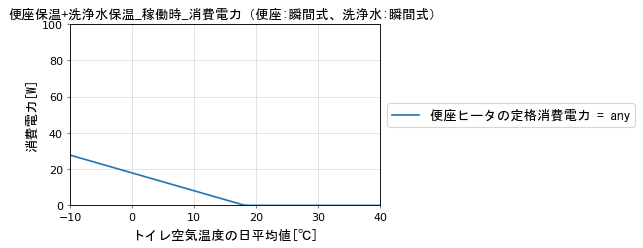

In [32]:
# 出力結果
plt.figure(figsize = (5, 3), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('便座保温+洗浄水保温_稼働時_消費電力（便座:瞬間式、洗浄水:瞬間式）', fontdict={'fontproperties':fp})

x_values = [x for x in range(-10, 45, 1)]
y_values = [P_opg_kp_sw_inst(theta_toilet_ave) for theta_toilet_ave in x_values]
plt.plot(x_values, y_values, label='便座ヒータの定格消費電力 = any')
        
ax=plt.gca()
ax.set_xlabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('消費電力[W]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(0, 120, 20), minor=False)
ax.set_ybound(lower=0, upper=100)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-') 
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

### 9.4　標準条件

#### 9.4.1　機器仕様

4人世帯の標準的な機器仕様として、下表の設定を用いることができる。

| 番号 | 便座ヒータの定格消費電力[W] | 洗浄水ヒータの定格消費電力[W] | 便座ヒータの加熱方式 | 洗浄水ヒータの加熱方式| 便座ヒータのオフ | 備考 |
|:----:| :-------------------------: | :---------------------------: | :------------------: | :-------------------: | :--: | :--: |  
|  00  | 50                          | 500                           | 非瞬間式             | 非瞬間式              | 可   | -    |
|  01  | 50                          | 1200                          | 非瞬間式             | 瞬間式                | 可   | 4人標準世帯のデフォルト設定 |
|  02  | 50                          | 500                           | 瞬間式               | 非瞬間式              | 可   | -    |
|  03  | 50                          | 1068                          | 瞬間式               | 瞬間式                | 不可 | -    |

In [33]:
Spec = {
    'ToiletSeat00':{
        'Prtd_opg_st' : 50,
        'Prtd_opg_wt' : 500,
        'seat_heater_type' : HeaterType.NonInst,
        'water_heater_type' : HeaterType.NonInst,
        'seat_heater_off' : True
    },
    'ToiletSeat01':{
        'Prtd_opg_st' : 50,
        'Prtd_opg_wt' : 1200,
        'seat_heater_type' : HeaterType.NonInst,
        'water_heater_type' : HeaterType.Inst,
        'seat_heater_off' : True
    },
    'ToiletSeat02':{
        'Prtd_opg_st' : 50,
        'Prtd_opg_wt' : 500,
        'seat_heater_type' : HeaterType.Inst,
        'water_heater_type' : HeaterType.NonInst,
        'seat_heater_off' : True
    },
    'ToiletSeat03':{
        'Prtd_opg_st' : 50,
        'Prtd_opg_wt' : 1068,
        'seat_heater_type' : HeaterType.Inst,
        'water_heater_type' : HeaterType.Inst,
        'seat_heater_off' : True
    }
}

#### 9.4.2　機器動作スケジュール

4人世帯の標準的なスケジュールとして、下表の設定を用いることができる。

| 番号 | スケジュール名称 | 備考 |
|:---: | :--------------: | :--: |
|  00  | 4人標準世帯1階   | -    |
|  01  | 4人標準世帯2階   | -    |

<p style="text-indent:2em">平日（1階）：</p>  

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  5|  0|  5|  0|  5|  0|  5|  0|  0|  0|  5|  5|  0|  5|  0|  0|  5|  5|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 55| 60| 55| 60| 55| 60| 55| 60| 60| 60| 55| 55| 60| 55| 60| 60| 55| 55| 

<p style="text-indent:2em">休日在宅（1階）：</p>   

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  0| 10|  5|  0|  0|  0|  0|  5|  0|  0|  5|  0|  0|  5|  5|  5|  5|  5|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 50| 55| 60| 60| 60| 60| 55| 60| 60| 55| 60| 60| 55| 55| 55| 55| 55| 

<p style="text-indent:2em">休日外出（1階）：</p>     

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  5|  5|  5|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  5|  5|  5|  5|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 55| 55| 55| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 55| 55| 55| 55| 

<p style="text-indent:2em">平日（2階）：</p>   

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  0| 10|  5|  0|  0|  0|  0|  0|  0|  0|  0|  5|  5|  5|  5|  5|  0| 10|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 50| 55| 60| 60| 60| 60| 60| 60| 60| 60| 55| 55| 55| 55| 55| 60| 50| 

<p style="text-indent:2em">休日在宅（2階）：</p>    

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  0|  0| 10|  5|  5|  5|  5|  0|  0|  0|  5|  5|  0|  0|  5|  0| 10|  0|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 50| 55| 55| 55| 55| 60| 60| 60| 55| 55| 60| 60| 55| 60| 50| 60| 

<p style="text-indent:2em">休日外出（2階）：</p>     

|時刻                   |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                  | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間_加温[\* 60 s] |  0|  0|  0|  0|  0|  0|  0|  0| 15|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  5|  5| 10|  0|  
|稼働時間_保温[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 45| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 55| 55| 50| 60| 

In [34]:
Schedule= {
    '1F' : {
        'Weekdays' : {
            'opg_ht' : [0]*6    +[300]*1  +[0]*1    +[300]*1  +[0]*1    + [300]*1  +[0]*1    +[300]*1  +[0]*3    +[300]*2  +[0]*1    +[300]*1  +[0]*2    +[300]*2,
            'opg_kp' : [3600]*6 +[3300]*1 +[3600]*1 +[3300]*1 +[3600]*1 + [3300]*1 +[3600]*1 +[3300]*1 +[3600]*3 +[3300]*2 +[3600]*1 +[3300]*1 +[3600]*2 +[3300]*2
        },
        'Holidays_st' : {
            'opg_ht' : [0]*7    +[600]*1  +[300]*1  +[0]*4    +[300]*1  +[0]*2    +[300]*1  +[0]*2    +[300]*5,
            'opg_kp' : [3600]*7 +[3000]*1 +[3300]*1 +[3600]*4 +[3300]*1 +[3600]*2 +[3300]*1 +[3600]*2 +[3300]*5
        },
        'Holidays_go' : {
            'opg_ht' : [0]*6    +[300]*3  +[0]*11    +[300]*4,
            'opg_kp' : [3600]*6 +[3300]*3 +[3600]*11 +[3300]*4
        }
    },
     '2F' : {
        'Weekdays' : {
            'opg_ht' :  [0]*7    +[600]*1  +[300]*1  +[0]*8    +[300]*5  +[0]*1    +[300]*1,
            'opg_kp' :  [3600]*7 +[3000]*1 +[3300]*1 +[3600]*8 +[3300]*5 +[3600]*1 +[3300]*1
        },
        'Holidays_st' : {
            'opg_ht' : [0]*8    +[600]*1  +[300]*4  +[0]*3    +[300]*2  +[0]*2    +[300]*1  +[0]*1    +[600]*1  +[0]*1,
            'opg_kp' : [3600]*8 +[3000]*1 +[3300]*4 +[3600]*3 +[3300]*2 +[3600]*2 +[3300]*1 +[3600]*1 +[3000]*1 +[3600]*1
        },
        'Holidays_go' : {
            'opg_ht' : [0]*8    +[900]*1  +[0]*11    +[300]*2  +[600]*1  +[0]*1,
            'opg_kp' : [3600]*8 +[2700]*1 +[3600]*11 +[3300]*2 +[3000]*1 +[3600]*1
        }
    }
}

In [35]:
def plot_hourly_bar_chart(fig_title, y_value_sets, schedule_name, app_status_types, 
                          y_label, y_lower, y_upper, y_interval, y_convert_unit):
    '''横軸が時刻（1時間間隔、0～23時間）の棒グラフを作成する'''
    # fig_title：図のタイトル
    # y_value_sets：y軸の値
    # schedule_name：スケジュール名（string型）
    # app_status_types：動作状態のタイプ（dictionary型）
    # y_label：y軸のラベル
    # y_lower：y軸の表示の下限
    # y_ upper：y軸の表示の上限
    # y_ interval：y軸の目盛間隔
    # y_convert_unit：y軸の単位換算係数

    # 日本語フォント
    fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)
    
    # 既存スタイルの使用
    plt.style.use('seaborn-whitegrid')

    # サブプロットの作成
    plt.figure(figsize=(12, 3), dpi=80)
    
    # サブプロットのタイトル
    plt.suptitle(fig_title, fontdict={'fontproperties':fp}, fontsize=14)
    
    # 生活時間タイプ
    time_use_types = [ ('Weekdays','平日'), ('Holidays_st','休日在宅'), ('Holidays_go','休日外出') ]

    for i, time_use_type in enumerate(time_use_types):
        # サブプロットの指定
        ax = plt.subplot2grid((1, 3), (0, i))  
        
        for j, app_status_type in enumerate(list(app_status_types)):
            # 棒グラフの作成
            # x軸の値
            x_value = [k for k in range(24)]
            # y軸の値（24時間×動作状態×3スケジュール）
            y_value_sets_schedule = y_value_sets
            # y軸の値（24時間×動作状態）
            y_value_sets_time_use = y_value_sets_schedule[time_use_type[0]]
            # y軸の値（24時間->単位変換）
            y_value = np.array(y_value_sets_time_use[app_status_type]) * y_convert_unit
            # データ系列名
            app_status_type_jp = app_status_types[app_status_type]
            if len(y_value) > 0:
                if j == 0:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp)
                    y_bottom = y_value
                else:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp, bottom=y_bottom)
                
        # グラフのタイル
        schedule_name_jp = schedule_name
        ax.set_title(schedule_name_jp +'(' + time_use_type[1] + ')' , fontdict={'fontproperties':fp})

        # x軸
        # タイトル
        ax.set_xlabel(u'時刻', fontdict={'fontproperties':fp})
        # 目盛りの位置／ラベル／形式
        # 主目盛
        ax.set_xticks(np.arange(0, 25, 3), minor=False)
        ax.set_xticklabels(np.array([k*3 for k in range(8)]+[0]).astype('str'), minor=False, visible=True)
        ax.tick_params(axis='x', which ='major', direction='in', length=3)
        # 補助目盛
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xticklabels(np.array([k for k in range(24)]+[0]).astype('str'), minor=True, visible=False)
        ax.tick_params(axis='x', which ='minor', direction='in', length=3)
        # 表示の上限・下限
        ax.set_xbound(lower=0, upper=24)

        # y軸
        #タイトル
        ax.set_ylabel(y_label, fontdict={'fontproperties':fp}) 
        # 目盛りの位置／形式
        #ax.set_yticks(np.arange(0, 30, 5))
        ax.set_yticks(np.arange(y_lower, y_upper+y_interval, y_interval))
        ax.tick_params(axis='y', which ='major', direction='in', length=3)
        # 表示の上限・下限
        ax.set_ybound(lower=y_lower, upper=y_upper)

        # グラフの枠
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')

        # 主目盛りのグリッド
        ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')

    # 凡例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True,  prop=fp)

    # グラフの重なりを解消
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
  
    plt.show()

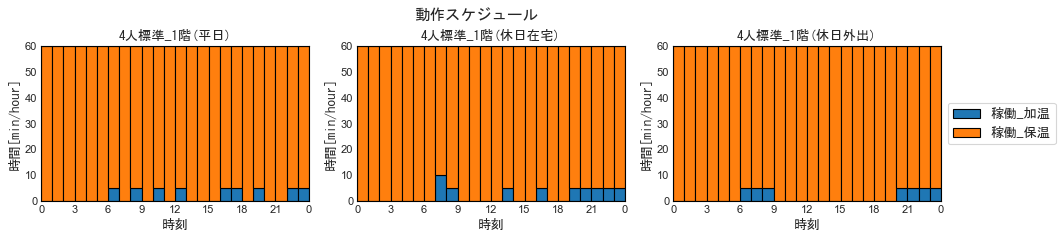

In [36]:
# 機器動作スケジュールの確認
plot_hourly_bar_chart('動作スケジュール', 
                      Schedule['1F'], 
                      '4人標準_1階',
                      {'opg_ht':'稼働_加温', 'opg_kp':'稼働_保温'},
                       '時間[min/hour]', 0, 60, 10, 1/60)

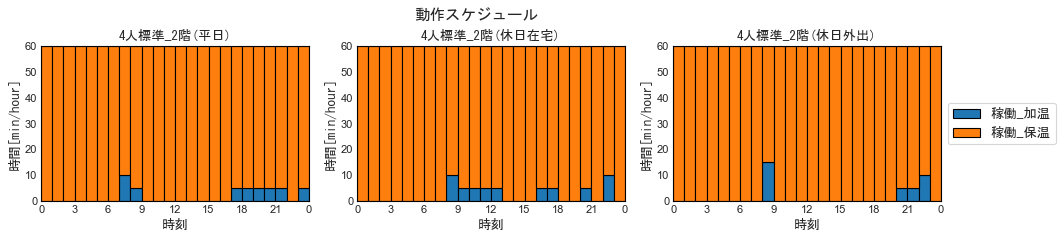

In [37]:
# 機器動作スケジュールの確認
plot_hourly_bar_chart('動作スケジュール', 
                      Schedule['2F'], 
                      '4人標準_2階',
                      {'opg_ht':'稼働_加温', 'opg_kp':'稼働_保温'},
                       '時間[min/hour]', 0, 60, 10, 1/60)

#### 9.4.3　暖房便座の機能に関する居住者の使用行動

居住者の使用行動は、通年で暖房便座を使用する場合とトイレ空気温度に応じて使用する場合との2パターンを想定する。

| 番号 |概要                                     | 備考 |
|:----:| :-------------------------------------: | :--: |  
|  00  | 通年で暖房便座を使用する                | - |
|  01  | トイレ空気温度に応じて暖房便座を使用する| 4人標準世帯の既定値 |


In [38]:
UserBehavior = {
    'UserBehavior00' : 'all_year_round', 
    'UserBehavior01' : 'at_lower_temp', 
}

In [39]:
def get_seat_heater_switch(seat_heater_off, user_behavior_seat_heater, theta_toilet_ave):
    '''便座ヒータの電源スイッチの状態を決定する[On/Off]'''
    # seat_heater_off：便座ヒータのオフの可否[True:オフ可、False：オフ不可](Boolean型)
    # user_behavior_seat_heater：暖房便座の機能に関する居住者の使用行動[all_year_round/ at_lower_temp](Enum型)
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    if seat_heater_off is False:
        return HeaterSwitch.On
    else:
        if user_behavior_seat_heater == 'all_year_round':
            return use_seat_heater_all_year_round()
        elif user_behavior_seat_heater == 'at_lower_temp':
            return use_seat_heater_at_lower_temp(theta_toilet_ave)
        else:
            try:
                raise Exception('使用行動タイプに不正があります。')
            except Exception:
                raise

通年で暖房便座の機能を使用する場合（標準条件）、便座ヒータの電源は常にオンとする。

In [40]:
def use_seat_heater_all_year_round():
    '''通年で暖房便座の機能を使用する場合'''
    
    return HeaterSwitch.On

トイレ空気温度に応じて暖房便座の機能を使用する場合、トイレ空気温度の日平均値が20℃以上の場合に暖房便座ヒータの電源をオフとする。

In [41]:
def use_seat_heater_at_lower_temp(theta_toilet_ave):
    '''トイレ空気温度に応じて暖房便座の機能を使用する場合'''
    # theta_toilet_ave：トイレ空気温度の日平均値[C]
    
    if theta_toilet_ave < 20:
        seat_heater_switch = HeaterSwitch.On
    else:
        seat_heater_switch = HeaterSwitch.Off
    
    return seat_heater_switch

### 9.5　トイレ空気温度の日平均値

トイレ空気温度が直接的にも求まらない場合、日平均外気温度および住宅の熱損失係数を用いて式(11)により推定した値を用いることができる。

<p style="text-indent:2em">暖房方式が居室間欠の場合：</p>  
<p style="text-indent:4em">1階：</p>   
$$ 
\begin{equation*}
    \displaystyle \theta_{toilet,ave,d} = \left( 0.0580 \times Q + 0.5186 \right) \times \theta_{ex,ave,d} + \left( -1.614 \times Q + 16.88 \right)
\end{equation*}
$$
<div style="text-align: right;"> (11a-1) </div>
    
<p style="text-indent:4em">2階：</p>   
$$ 
\begin{equation*}
    \displaystyle \theta_{toilet,ave,d} = \left( 0.0499 \times Q + 0.6023 \right) \times \theta_{ex,ave,d} + \left( -1.493 \times Q + 14.15 \right)
\end{equation*}
$$
<div style="text-align: right;"> (11a-2) </div>

<p style="text-indent:2em">暖房方式が全館連続の場合：</p>    
<p style="text-indent:4em">1階：</p>    
$$ 
\begin{equation*}
    \displaystyle \theta_{toilet,ave,d} = \left( 0.0669 \times Q + 0.3721 \right) \times \theta_{ex,ave,d} + \left( -1.738 \times Q + 19.703 \right)
\end{equation*}
$$
<div style="text-align: right;"> (11b-1) </div>
    
<p style="text-indent:4em">2階：</p> 
$$ 
\begin{equation*}
    \displaystyle \theta_{toilet,ave,d} = \left( 0.0619 \times Q + 0.4117 \right) \times \theta_{ex,ave,d} + \left( -1.655 \times Q + 17.85 \right)
\end{equation*}
$$
<div style="text-align: right;"> (11b-2) </div>

ここで、  

$\theta_{ex,ave,d}$：日付$d$における外気温の日平均値[℃]  
$\theta_{toilet,ave,d}$：日付$d$におけるトイレ空気温度の日平均値[℃]  

である。

In [42]:
class HeatingType(Enum):
    '''暖房方式'''
    # HabitableRoom：居室間欠
    # WholeHouse：全館連続

    HabitableRoom = 'habitable_room'
    WholeHouse = 'whole_house'

In [43]:
class Floor(Enum):
    '''階'''
    # 1F：1階
    # 2F：2階

    FirstFloor = 'first_floor'
    SecondFloor = 'second_floor'

In [44]:
def get_theta_toilet_ave(theta_ex_ave, Q_value, heating_type, floor):
    '''トイレ空気温度の日平均値を計算する[℃]'''
    # theta_ex_ave：外気温度の日平均値[C]
    # Q_value：住宅の熱損失係数[W/m2] 
    # heating_type：暖房方式[居室間欠、全館連続] 
    # floor：階[1階、2階] 
    
    if heating_type == HeatingType.HabitableRoom:
        if floor == Floor.FirstFloor:
            theta_toilet_ave = (0.0580 * Q_value + 0.5186) * theta_ex_ave + (-1.612 * Q_value + 16.88)
        elif floor == Floor.SecondFloor:
            theta_toilet_ave = (0.0499 * Q_value + 0.6023) * theta_ex_ave + (-1.493 * Q_value + 14.15)
    elif heating_type == HeatingType.WholeHouse:
        if floor == Floor.FirstFloor:
            theta_toilet_ave = (0.0669 * Q_value + 0.3721) * theta_ex_ave + (-1.738 * Q_value + 19.703)
        elif floor == Floor.SecondFloor:
            theta_toilet_ave = (0.0619 * Q_value + 0.4117) * theta_ex_ave + (-1.655 * Q_value + 17.85)
    else:
        try:
            raise Exception('階数に不正があります。')
        except Exception:
            raise
    
    return theta_toilet_ave

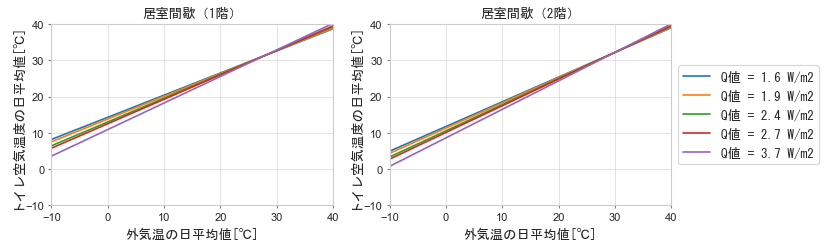

In [45]:
# 出力結果：居室間歇（1階）
plt.figure(figsize = (10, 3), dpi=80 )
plt.subplot2grid((1, 2), (0, 0))
plt.title('居室間歇（1階）', fontdict={'fontproperties':fp})

for i,Q_value in enumerate([1.6, 1.9, 2.4, 2.7, 3.7]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [get_theta_toilet_ave(theta_ex_ave, Q_value, HeatingType.HabitableRoom, Floor.FirstFloor) for theta_ex_ave in x_values]
    plt.plot(x_values, y_values)
        
ax=plt.gca()
ax.set_xlabel('外気温の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(-10, 45, 10), minor=False)
ax.set_ybound(lower=-10, upper=40)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')     
ax.tick_params(direction='out', length=3, width=1, color='gray')

# 出力結果：居室間歇（2階）
plt.subplot2grid((1, 2), (0, 1))
plt.title('居室間歇（2階）', fontdict={'fontproperties':fp})

for i,Q_value in enumerate([1.6, 1.9, 2.4, 2.7, 3.7]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [get_theta_toilet_ave(theta_ex_ave, Q_value, HeatingType.HabitableRoom, Floor.SecondFloor) for theta_ex_ave in x_values]
    plt.plot(x_values, y_values, label='Q値 = '+str(Q_value)+' W/m2')
        
ax=plt.gca()
ax.set_xlabel('外気温の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(-10, 45, 10), minor=False)
ax.set_ybound(lower=-10, upper=40)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')     
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

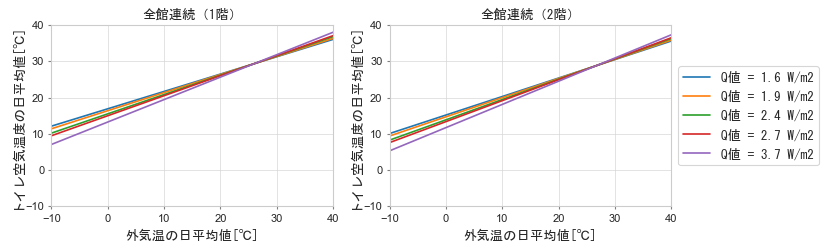

In [46]:
# 出力結果：全館連続（1階）
plt.figure(figsize = (10, 3), dpi=80 )
plt.subplot2grid((1, 2), (0, 0))
plt.title('全館連続（1階）', fontdict={'fontproperties':fp})

for i,Q_value in enumerate([1.6, 1.9, 2.4, 2.7, 3.7]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [get_theta_toilet_ave(theta_ex_ave, Q_value, HeatingType.WholeHouse, Floor.FirstFloor) for theta_ex_ave in x_values]
    plt.plot(x_values, y_values)
        
ax=plt.gca()
ax.set_xlabel('外気温の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(-10, 45, 10), minor=False)
ax.set_ybound(lower=-10, upper=40)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')     
ax.tick_params(direction='out', length=3, width=1, color='gray')

# 出力結果：全館連続（2階）
plt.subplot2grid((1, 2), (0, 1))
plt.title('全館連続（2階）', fontdict={'fontproperties':fp})

for i,Q_value in enumerate([1.6, 1.9, 2.4, 2.7, 3.7]):
    x_values = [x for x in range(-10, 45, 1)]
    y_values = [get_theta_toilet_ave(theta_ex_ave, Q_value, HeatingType.WholeHouse, Floor.SecondFloor) for theta_ex_ave in x_values]
    plt.plot(x_values, y_values, label='Q値 = '+str(Q_value)+' W/m2')
        
ax=plt.gca()
ax.set_xlabel('外気温の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_xticks(np.arange(-10, 45, 10), minor=False)
ax.set_xbound(lower=-10, upper=40)

ax.set_ylabel('トイレ空気温度の日平均値[℃]', fontdict={'fontproperties':fp})
ax.set_yticks(np.arange(-10, 45, 10), minor=False)
ax.set_ybound(lower=-10, upper=40)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')     
ax.tick_params(direction='out', length=3, width=1, color='gray')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True, prop=fp)

plt.show()

### 付録1：サンプルコード

4人標準世帯の標準条件について、サンプルコードを示す。

In [47]:
def get_spec(app_type):
    '''機器仕様を取得する'''
    # app_type：機器タイプ
    
    # 機器仕様の取得
    try:
        spec = Spec[app_type]
    except:
        raise Exception('機器タイプの入力に不正があります。')     
    
    Prtd_opg_st = spec['Prtd_opg_st']
    Prtd_opg_wt = spec['Prtd_opg_wt']
    seat_heater_type = spec['seat_heater_type']
    water_heater_type = spec['water_heater_type']
    seat_heater_off = spec['seat_heater_off']
    
    return Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_off

Example:

In [48]:
ex_Prtd_opg_st, ex_Prtd_opg_wt, ex_seat_heater_type, ex_water_heater_type, ex_seat_heater_off = get_spec('ToiletSeat01')
ex_Prtd_opg_st, ex_Prtd_opg_wt, ex_seat_heater_type, ex_water_heater_type, ex_seat_heater_off

(50, 1200, <HeaterType.NonInst: 'noninst'>, <HeaterType.Inst: 'inst'>, True)

In [49]:
def get_dt(time_use_type, time_of_day, schedule_name):
    '''機器動作スケジュールを取得する'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23）
    # schedule_name：スケジュール名
     
    # スケジュールの取得
    try:
        schedule_set = Schedule[schedule_name][time_use_type]
    except:
        raise Exception('スケジュール名の入力に不正があります。')    
               
    # 動作状態のタイプ
    app_status_types = list(schedule_set)
    
    # 動作状態ごとの継続時間[s]の取得
    for i, app_status_type in enumerate(app_status_types):
        if app_status_type == 'opg_ht':
            dt_opg_ht = schedule_set[app_status_type][time_of_day]
        elif app_status_type == 'opg_kp':
            dt_opg_kp= schedule_set[app_status_type][time_of_day]
        else:
            raise Exception
            
    # 時間超過の確認
    check_duration([dt_opg_ht, dt_opg_kp]) 
    
    return dt_opg_ht, dt_opg_kp

Example:

In [50]:
ex_dt_opg_ht, ex_dt_opg_kp = get_dt('Weekdays', 6,'1F')
ex_dt_opg_ht, ex_dt_opg_kp

(300, 3300)

In [51]:
def get_user_behavior(user_behavior_type):
    '''居住者の使用行動を取得する'''
    # user_behavior_type：居住者の使用行動タイプ
    
    # 居住者の使用行動の取得
    try:
        behavior_seat_heater = UserBehavior[user_behavior_type]
    except:
        raise Exception('居住者の使用行動タイプの入力に不正があります。')     
    
    return behavior_seat_heater

Example:

In [52]:
ex_behavior_seat_heater = get_user_behavior('UserBehavior01')
ex_behavior_seat_heater

'at_lower_temp'

In [53]:
def calc_EE_opg(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, dt_opg_ht, dt_opg_kp, 
                seat_heater_switch, theta_toilet_ave):
    '''消費電力量[Wh]を計算する'''
    # Prtd_opg_st：便座ヒータの定格消費電力[W]  
    # Prtd_opg_wt：洗浄水ヒータの定格消費電力[W]  
    # seat_heater_type：便座ヒータの加熱方式[非瞬間方式、瞬間方式](Enum型)    
    # water_heater_type：洗浄水ヒータの加熱方式[非瞬間方式、瞬間方式](Enum型)  
    # dt_opg_ht：加温が機能することによる稼働時間の合計[s]
    # dt_opg_kp：保温が機能することによる稼働時間の合計[s]
    # seat_heater_switch：便座ヒータの電源スイッチ[オフ、オン] (Enum型)
    # theta_toilet_ave：トイレ空気温度の日平均値[C]  
    
    # 加温が機能することによる稼働時の消費電力[W]
    p_opg_ht = P_opg_ht(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_switch, theta_toilet_ave)
    
    # 保温が機能することによる稼働時の消費電力[W]
    p_opg_kp = P_opg_kp(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_switch, theta_toilet_ave)
    
    # 稼働時における消費電力量[Wh]
    ee_opg = EE_opg(p_opg_ht, p_opg_kp, dt_opg_ht, dt_opg_kp)
    
    return ee_opg

Example:

In [54]:
ex_theta_toilet_ave = get_theta_toilet_ave(0, 2.7, HeatingType.HabitableRoom, Floor.FirstFloor)
ex_theta_toilet_ave

12.5276

In [55]:
ex_seat_heater_switch = get_seat_heater_switch(ex_seat_heater_off, ex_behavior_seat_heater, ex_theta_toilet_ave)
ex_seat_heater_switch

<HeaterSwitch.On: 'on'>

In [56]:
ex_EE_opg = calc_EE_opg(ex_Prtd_opg_st, ex_Prtd_opg_wt, ex_seat_heater_type, ex_water_heater_type,ex_dt_opg_ht, ex_dt_opg_kp, 
                        ex_seat_heater_switch, ex_theta_toilet_ave)
ex_EE_opg

29.918299323333336

In [57]:
def calc_EE_app(EE_opg):
    '''消費電力量[Wh]を計算する'''
    # EE_opg：稼働時における消費電力量[Wh]
    
    return EE_app(EE_opg)

Example:

In [58]:
ex_EE_app = calc_EE_app(ex_EE_opg)
ex_EE_app

29.918299323333336

In [59]:
def calc_EE_ToiletSeat_verP4(time_use_type, time_of_day, 
                             app_type, schedule_name, user_behavior_type, theta_ex_ave, Q_value, heating_type, floor):
    '''温水暖房洗浄便座の単位時間当たりの消費電力量を計算する（ver自立P4）'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23） 
    # app_type：機器タイプ  
    # schedule_name：スケジュール名 ['1F', '2F']
    # user_behavior_type：使用行動タイプ 
    # theta_ex_ave：外気温度の日平均値[C]
    # Q_value：住宅の熱損失係数[W/m2] 
    # heating_type：暖房方式[居室間欠、全館連続] 
    # floor：階[1階、2階] 
    
    # 機器動作スケジュール[s]を取得
    dt_opg_ht, dt_opg_kp = get_dt(time_use_type, time_of_day, schedule_name)
    
    # 機器仕様を取得
    Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, seat_heater_off = get_spec(app_type)
    
    # 使用行動を取得
    behavior_seat_heater = get_user_behavior(user_behavior_type)
    
    # トイレ空気温度の日平均値[C]を取得
    theta_toilet_ave = get_theta_toilet_ave(theta_ex_ave, Q_value, heating_type, floor)
    
    # 便座ヒータの電源スイッチ[オフ、オン] を取得
    seat_heater_switch = get_seat_heater_switch(seat_heater_off, behavior_seat_heater, theta_toilet_ave)
    
    # 稼働時における消費電力量[Wh]を計算
    EE_opg = calc_EE_opg(Prtd_opg_st, Prtd_opg_wt, seat_heater_type, water_heater_type, dt_opg_ht, dt_opg_kp, 
                         seat_heater_switch, theta_toilet_ave)
    
    # 消費電力量[Wh]を計算
    EE_app = calc_EE_app (EE_opg)
    
    return EE_app, EE_opg

Example:

In [60]:
ex_EE_ToiletSeat = calc_EE_ToiletSeat_verP4('Weekdays', 6, 
                             'ToiletSeat01', '1F', 'UserBehavior01', 0, 2.7, HeatingType.HabitableRoom, Floor.FirstFloor)
ex_EE_ToiletSeat

(29.918299323333336, 29.918299323333336)

### 付録2：サンプルコードによる時刻別消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより平日、休日在宅、休日外出の時刻別消費電力量を計算した結果を示す。

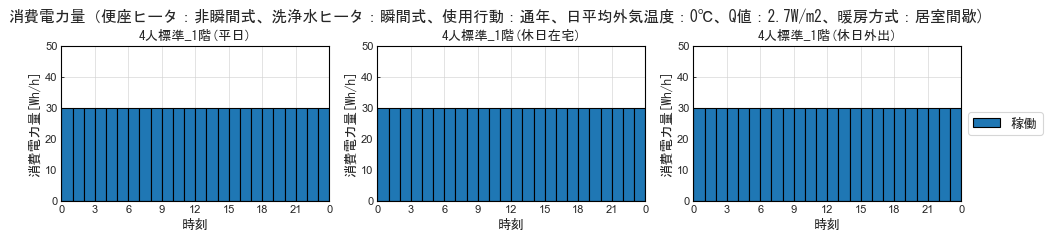

In [61]:
# 消費電力量の計算
# 入力
time_use_type = [['Weekdays'], ['Holidays_st'], ['Holidays_go']]
time_of_day = [i for i in range(0, 24, 1)]
app_type = 'ToiletSeat01'
schedule_name = '1F'
user_behavior_type = 'UserBehavior00'
theta_ex_ave = 0
Q_value  = 2.7
heating_type = HeatingType.HabitableRoom
floor = Floor.FirstFloor

# 消費電力量の計算
ee_app, ee_opg = np.vectorize(calc_EE_ToiletSeat_verP4)(time_use_type, time_of_day,
                                                 app_type, schedule_name, user_behavior_type,
                                                 theta_ex_ave, Q_value, heating_type, floor)

# 消費電力量の計算結果
EE_Results= {
    'Weekdays' : {
        'opg' : ee_opg[0],
    },
    'Holidays_st' : {
        'opg' : ee_opg[1],
    },
    'Holidays_go' : {
        'opg' : ee_opg[2],
    }
}

# 消費電力量の計算結果のグラフ
# グラフのタイトル
seat_heater_type_j =  {'noninst':'非瞬間式', 'inst':'瞬間式'}[Spec[app_type]['seat_heater_type'].value]
water_heater_type_j = {'noninst':'非瞬間式', 'inst':'瞬間式'}[Spec[app_type]['water_heater_type'].value]
behavior_type_j = {'UserBehavior00':'通年', 'UserBehavior01':'省エネ'} [user_behavior_type]
heating_type_j = {HeatingType.HabitableRoom:'居室間歇', HeatingType.WholeHouse:'全館連続'} [heating_type]

chart_title = '消費電力量（' \
                + '便座ヒータ：' + seat_heater_type_j + '、' \
                + '洗浄水ヒータ：' + water_heater_type_j + '、' \
                + '使用行動：'   + behavior_type_j + '、' \
                + '日平均外気温度：' + str(theta_ex_ave) + '℃、'\
                + 'Q値：' + str(Q_value) + 'W/m2、'\
                + '暖房方式：' + heating_type_j \
                + ')'

# グラフの表示
plot_hourly_bar_chart(chart_title, 
                     EE_Results, 
                      '4人標準_1階',
                      {'opg':'稼働'},
                       '消費電力量[Wh/h]', 0, 50, 10, 1)

### 付録3：サンプルコードによる年間消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより年間消費電力量を計算した結果を示す。

In [62]:
def calc_annual_EE_app(app_type, schedule_name, user_behavior_type, 
                   theta_ex_ave, Q_value, heating_type, floor):
    '''年間消費電力量[Wh/year]を計算する'''
    # app_type：機器タイプ  
    # schedule_name：スケジュール名 ['1F', '2F']
    # user_behavior_type：使用行動タイプ 
    # theta_ex_ave：外気温度の日平均値[C]
    # Q_value：住宅の熱損失係数[W/m2] (List型)
    # heating_type：暖房方式[居室間欠、全館連続] 
    # floor：階[1階、2階]  

    def calc_daily_EE_app(schedule, app_type, schedule_name, user_behavior_type,
                         theta_ex_ave, Q_value, heating_type, floor):
        '''1日あたりの消費電力量[Wh/day]を計算する'''
        hourly_EE_app = [ calc_EE_ToiletSeat_verP4(schedule, t,
                                                   app_type, schedule_name, user_behavior_type,
                                                   theta_ex_ave, Q_value, heating_type, floor)[1] for t in range(0, 24, 1) ]
        return sum( hourly_EE_app )
    
    daily_EE_app = [ calc_daily_EE_app(schedule, app_type, schedule_name, user_behavior_type,
                                       theta_ex_ave[i], Q_value, heating_type, floor) for i, schedule in enumerate(get_calendar()) ]
    return sum( daily_EE_app )

In [63]:
# 年間消費電力量[kWh/year]：1階、6地域
ex_annual_EE_app = calc_annual_EE_app('ToiletSeat01', '1F', 'UserBehavior01',
                                      calc_theta_ex_ave('region6'), get_Q_value('region6'),
                                      HeatingType.HabitableRoom, Floor.FirstFloor)
print('年間消費電力量：' + str(ex_annual_EE_app/1000) + ' kWh/年')

年間消費電力量：80.59254295981779 kWh/年


In [64]:
# 年間消費電力量[kWh/year]：2階、6地域
ex_annual_EE_app = calc_annual_EE_app('ToiletSeat01', '2F', 'UserBehavior01',
                                      calc_theta_ex_ave('region6'), get_Q_value('region6'),
                                      HeatingType.HabitableRoom, Floor.SecondFloor)
print('年間消費電力量：' + str(ex_annual_EE_app/1000) + ' kWh/年')

年間消費電力量：100.70069935726295 kWh/年
